# Exercise 10.2

In this exercise we adapt the genetic algorithm from exercise $09$ to exploit more than one core by means of parallelization. Then we compare two version of the parallelized code, one with interactions between the processes and one where all processes run independently.

## Parameters of simulation

We solve the TSP for $n=110$ capitals of italian provinces, first with a parallelized genetic algorithm run on $11$ nodes that periodically exchange their best individual (referred to as $we$, i.e. with exchanges), and then with $11$ parallel runs that do not interact with each other ($woe$, without exchanges).
For both the cases we use a populaton of $M=500$ individuals carried on for $N=2000$ generations.
In order for the comparison to be fair, both type of simulations have populations the same size and the same crossing and mutation probabilities, which respectively are $p_c = 95\%$ and $p_m = 10\%$.  
The number of exchanges/migrations that happen in the fully parallelized code are $N_{migr}= 100$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#array of nodes
nodes = [i for i in range(11)]
#number of generations
n_generations = int(np.loadtxt("INPUT/input.dat", usecols=1, max_rows=1))

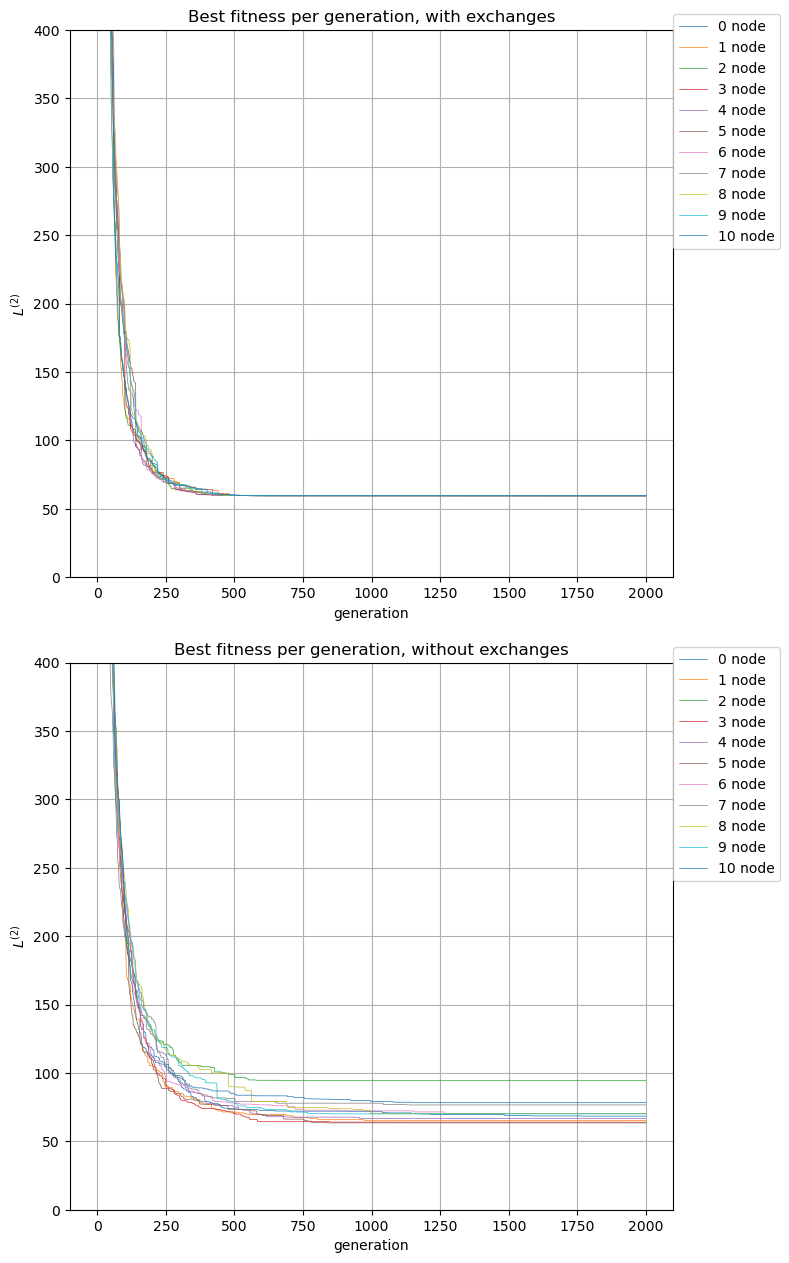

In [10]:
# Create a figure with two subplots arranged vertically
fig, axx = plt.subplots(2, 1, figsize=(8, 12.8), tight_layout=True)

# First subplot: Best fitness per generation with exchanges
axx[0].set_ylim((0., 400.))  # Set y-axis limits for the first subplot
axx[0].set_title("Best fitness per generation, with exchanges")  # Set title for the first subplot
axx[0].set_xlabel("generation")  # Set x-axis label for the first subplot
axx[0].set_ylabel(r"$L^{(2)}$")  # Set y-axis label for the first subplot with LaTeX formatting
for node in nodes:
    # Load data for best fitness per generation with exchanges for each node
    n_gens, best_fitness = np.loadtxt("OUTPUT1/best_fitness"+str(node)+".dat", usecols=(0, 1), skiprows=1, unpack=True)
    # Plot best fitness per generation for the current node
    axx[0].plot(n_gens, best_fitness, linewidth=0.5, marker=" ", label=f"{node} node")
    axx[0].grid(True)  # Enable grid for the first subplot
axx[0].legend(loc=(1., 0.6))  # Add legend for the first subplot

# Second subplot: Best fitness per generation without exchanges
axx[1].set_ylim((0., 400.))  # Set y-axis limits for the second subplot
axx[1].set_title("Best fitness per generation, without exchanges")  # Set title for the second subplot
axx[1].set_xlabel("generation")  # Set x-axis label for the second subplot
axx[1].set_ylabel(r"$L^{(2)}$")  # Set y-axis label for the second subplot with LaTeX formatting
for node in nodes:
    # Load data for best fitness per generation without exchanges for each node
    n_gens, best_fitness = np.loadtxt("OUTPUT0/best_fitness"+str(node)+".dat", usecols=(0, 1), skiprows=1, unpack=True)
    # Plot best fitness per generation for the current node
    axx[1].plot(n_gens, best_fitness, linewidth=0.5, marker=" ", label=f"{node} node")
    axx[1].grid(True)  # Enable grid for the second subplot
axx[1].legend(loc=(1., 0.6))  # Add legend for the second subplot


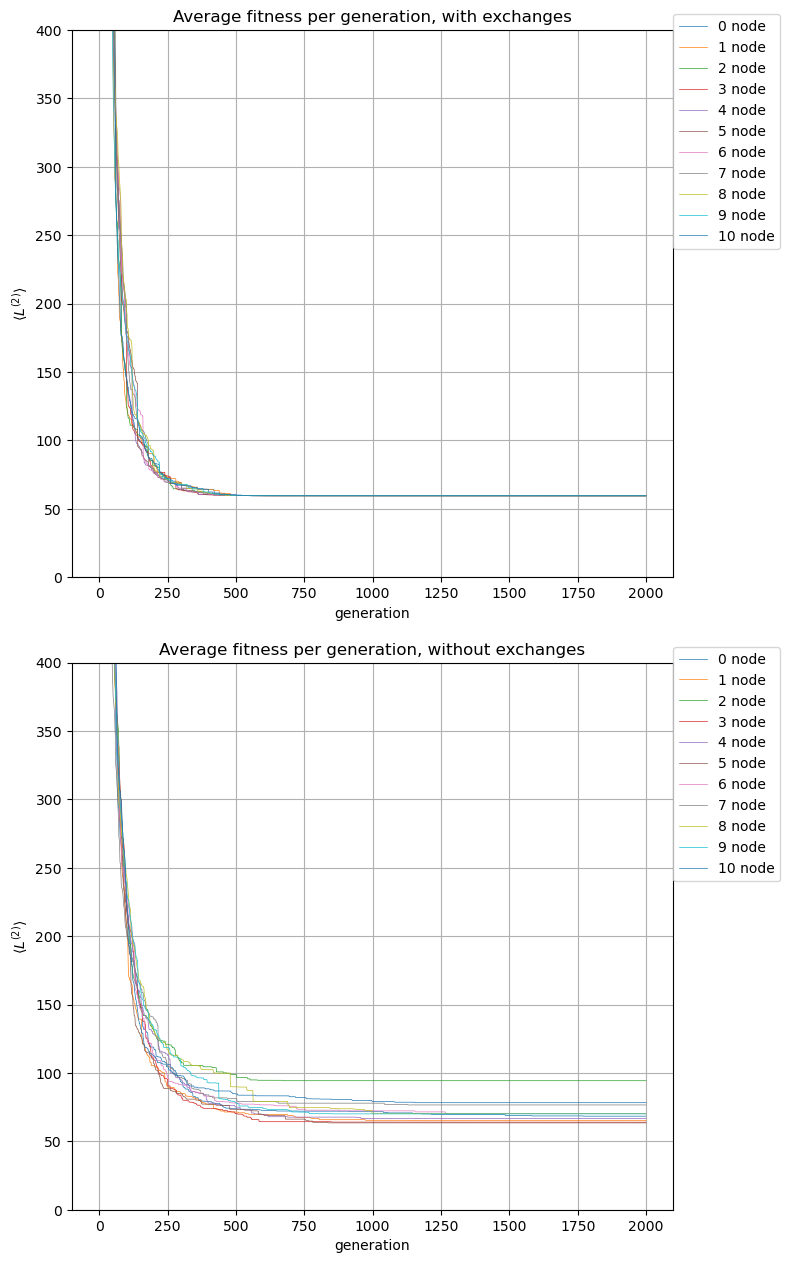

In [11]:
# Create a figure with two subplots arranged vertically
fig, axx = plt.subplots(2, 1, figsize=(8, 12.8), tight_layout=True)

# First subplot: Average fitness per generation with exchanges
axx[0].set_ylim((0., 400.))  # Set y-axis limits for the first subplot
axx[0].set_title("Average fitness per generation, with exchanges")  # Set title for the first subplot
axx[0].set_xlabel("generation")  # Set x-axis label for the first subplot
axx[0].set_ylabel(r"$\langle L^{(2)} \rangle$")  # Set y-axis label for the first subplot with LaTeX formatting
for node in nodes:
    # Load data for average fitness per generation with exchanges for each node
    n_gens, fitness = np.loadtxt("OUTPUT1/fitness"+str(node)+".dat", usecols=(0, 1), skiprows=1, unpack=True)
    # Plot average fitness per generation for the current node
    axx[0].plot(n_gens, fitness, linewidth=0.5, marker=" ", label=f"{node} node")
    axx[0].grid(True)  # Enable grid for the first subplot
axx[0].legend(loc=(1., 0.6))  # Add legend for the first subplot

# Second subplot: Average fitness per generation without exchanges
axx[1].set_ylim((0., 400.))  # Set y-axis limits for the second subplot
axx[1].set_title("Average fitness per generation, without exchanges")  # Set title for the second subplot
axx[1].set_xlabel("generation")  # Set x-axis label for the second subplot
axx[1].set_ylabel(r"$\langle L^{(2)} \rangle$")  # Set y-axis label for the second subplot with LaTeX formatting
for node in nodes:
    # Load data for average fitness per generation without exchanges for each node
    n_gens, fitness = np.loadtxt("OUTPUT0/fitness"+str(node)+".dat", usecols=(0, 1), skiprows=1, unpack=True)
    # Plot average fitness per generation for the current node
    axx[1].plot(n_gens, fitness, linewidth=0.5, marker=" ", label=f"{node} node")
    axx[1].grid(True)  # Enable grid for the second subplot
axx[1].legend(loc=(1., 0.6))  # Add legend for the second subplot


In [5]:
#find best node
best_final_fitnesses_we = [0 for i in range(np.shape(nodes)[0])]
for i in range(np.shape(nodes)[0]):
    best_final_fitnesses_we[i] = float(np.loadtxt("OUTPUT1/best_fitness"+str(nodes[i])+".dat", usecols=1, skiprows=n_generations, unpack=True))
minimum_node_we = best_final_fitnesses_we.index(min(best_final_fitnesses_we))

best_final_fitnesses_woe = [0 for i in range(np.shape(nodes)[0])]
for i in range(np.shape(nodes)[0]):
    best_final_fitnesses_woe[i] = float(np.loadtxt("OUTPUT0/best_fitness"+str(nodes[i])+".dat", usecols=1, skiprows=n_generations, unpack=True))
minimum_node_woe = best_final_fitnesses_woe.index(min(best_final_fitnesses_woe))

In [6]:
#load cities for simulation with exchanges
cities = np.loadtxt("cap_prov_ita.dat", usecols=(0, 1))
cities = np.transpose(cities)
cities_x = cities[0]
cities_y = cities[1]

In [7]:
#load genes
genes_we = np.loadtxt("OUTPUT1/genes"+str(minimum_node_we)+".dat", usecols=0, skiprows=1)
path_x_we = [0 for i in range(cities_x.shape[0])]
path_y_we = [0 for i in range(cities_y.shape[0])]

#load best permutation of cities
for i in range(genes_we.shape[0]):
    path_x_we[i] = cities_x[int(genes_we[i])]
    path_y_we[i] = cities_y[int(genes_we[i])]

#load genes
genes_woe = np.loadtxt("OUTPUT0/genes"+str(minimum_node_woe)+".dat", usecols=0, skiprows=1)
path_x_woe = [0 for i in range(cities_x.shape[0])]
path_y_woe = [0 for i in range(cities_y.shape[0])]

#load best permutation of cities
for i in range(genes_woe.shape[0]):
    path_x_woe[i] = cities_x[int(genes_woe[i])]
    path_y_woe[i] = cities_y[int(genes_woe[i])]

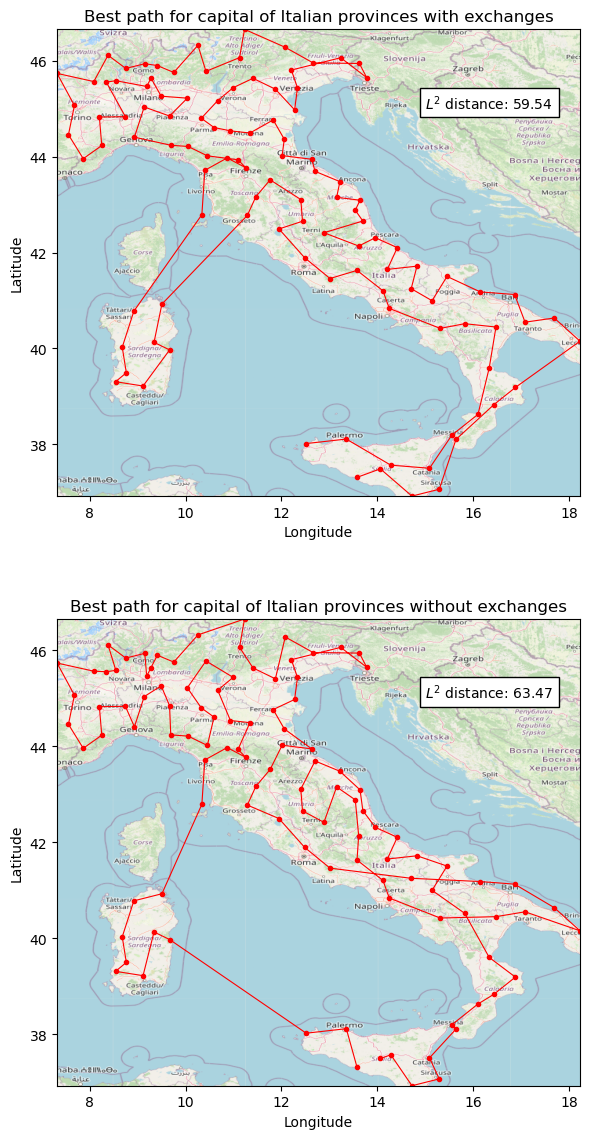

In [12]:
# Load the image of Italy
italy_m = plt.imread('italy.png')

# Define the bounding box for plotting
Bbox = (cities_x.min(), cities_x.max(), cities_y.min(), cities_y.max())

# Create a figure with two subplots arranged vertically
fig, axx = plt.subplots(2, 1, figsize=(6, 12), tight_layout=True)

# First subplot: Best path for capital of Italian provinces with exchanges
axx[0].plot(path_x_we, path_y_we, linewidth=0.8, marker=".", color='red')  # Plot the best path with exchanges
axx[0].set_title("Best path for capital of Italian provinces with exchanges")  # Set title for the first subplot
axx[0].set_ylabel("Latitude")  # Set y-axis label for the first subplot
axx[0].set_xlabel("Longitude")  # Set x-axis label for the first subplot
axx[0].text(15, 45, "$L^2$ distance: " + str(format(best_final_fitnesses_we[minimum_node_we], '.2f')), bbox=dict(facecolor='white', alpha=1))  # Display the L^2 distance
axx[0].imshow(italy_m, zorder=0, extent=Bbox, aspect='equal')  # Display the map of Italy as background for the plot

# Second subplot: Best path for capital of Italian provinces without exchanges
axx[1].plot(path_x_woe, path_y_woe, linewidth=0.8, marker=".", color='red')  # Plot the best path without exchanges
axx[1].set_title("Best path for capital of Italian provinces without exchanges")  # Set title for the second subplot
axx[1].set_ylabel("Latitude")  # Set y-axis label for the second subplot
axx[1].set_xlabel("Longitude")  # Set x-axis label for the second subplot
axx[1].text(15, 45, "$L^2$ distance: " + str(format(best_final_fitnesses_woe[minimum_node_woe], '.2f')), bbox=dict(facecolor='white', alpha=1))  # Display the L^2 distance
axx[1].imshow(italy_m, zorder=0, extent=Bbox, aspect='equal')  # Display the map of Italy as background for the plot